# Etivity 4: Comparison of Binary Classifiers

In this Etivity 4, I will use the seeds data set. More information can be found here: http://archive.ics.uci.edu/ml/datasets/seeds.
All columns in this data set are numerical (area of seeds, perimeter of seed, compactness of seed, length of kernel, width of kernel, asymmetry coefficient of seeds, length of kernel groove and type/ varieties). Even though the column is numerical, it looks like a categorical (ordinal) attribute. Each example is a wheat type with either 1 (Kama), 2 (Rosa), and 3 (Canadian).

I will train a binary classification model to predict the type. 

The type column is the dependent variable or target for classification, while all other columns are the predictors. I will use the common convention to refer to the predictors as X and to the target as y.

In the process of training the dataset will be split into a training set and a test set. The training set will be further split (multiple times) into a training and validation set in a cross-validation procedure for tuning the parameters of two alternative classifiers: SVM and Random Forest.

Note that any data preparation of the predictors needs to be applied separately to each of these sets.

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


## EDA

In [2]:
df = pd.read_csv(r"/Users/steffipoliwoda/Desktop/seeds.csv")
df.head()


,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [3]:
df['type'].value_counts()


3    70
2    70
1    70
Name: type, dtype: int64

I will check for missing values and outliers.

In [4]:
df.isna().sum()


area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

There are no missing values. I will check the boxplots for outliers. 

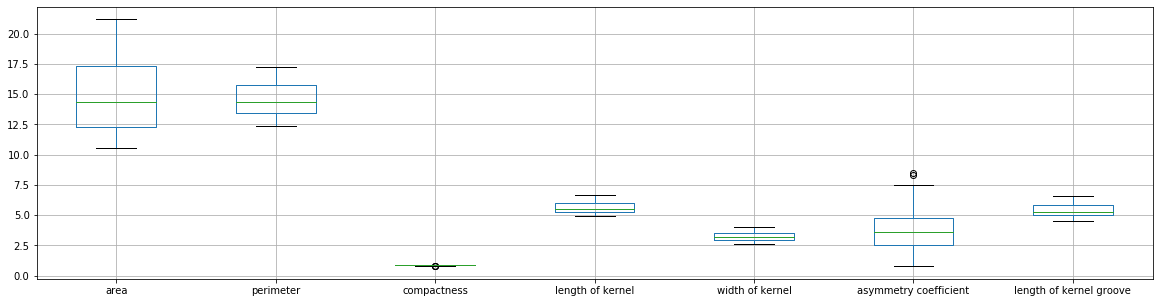

In [5]:
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()


The column asymmetry has outliers. We will apply log transformation followed by RobustScaler to asymmetry coefficient. To all other predictor columns we will apply StandardScaler.

## Data Preparation

First, I will transform the type column to binary.

In [6]:
mapper = {1: 1, 2 : 0, 3: 0}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()


0    140
1     70
Name: type, dtype: int64

I will attempt training SVM and Random Forest classifiers. I will tune their parameters, compare them and choose the best classifier for the problem. Here I will prepare a scikit-learn pipeline for data preparation (preprocessing pipeline), which I will apply later. The use of this pipelines ensures that preprocessing is applied separately to any training validation and test dataset without data leakage.

First, I need to prepare two lists of column names. The list names_outliers contains the names of the column to which I will apply log transformation followed by RobustScaler. The list names_no_outliers contains the names of all other predictor columns to which I will apply StandardScaler.

In [7]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient']
names_no_outliers = list(set(names_all) - set(names_outliers))


After splitting a dataset into a training and test datasets, the names of the columns are lost. This is the reason, I stored the names of the columns in lists above. I will use the following class in the preprocessing pipeline to put the names of the columns back. I need this to easily apply the different preparation strategies to the two groups of columns.

In [8]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)
    

Then I need another class to be able to select a particular group of columns.

In [9]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]
    

Finally, I can build the preprocessing pipeline. It first adds the column names back to a set of examples (that can be either a training, or a validation, or test set). Then it applies the two different data preparation strategies to the two groups of columns and unites them with FeatureUnion.

In [10]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

Now I can separate the columns into target and predictors and split the dataset into a training and test sets.

In [11]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)


The parameter `stratify=y` ensures both classes are represented in the same proportion in both the training and the test sets.

Note that after the split into a training and test sets, X_train and X_test are numpy arrays and no longer have column names. That's why I needed the class above to put the names of columns back in the preprocessing pipeline.

## Grid Search for Best Parameters of Classifiers

Next, I train an SVM classifier with the training set and a range of possible parameters in order to find the best parameters for SVM by cross-validation. To do this I will build another pipeline which includes the preprocessing pipeline and the SVM classifier. The pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation.

In [12]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_


Best CV score = 0.958:
Best parameters:  {'svm__C': 100, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}


/Users/steffipoliwoda/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


The parameter `refit=True` makes the GridSearchCV train an SVM classifier on the **whole training set** with the best parameters found. This best SVM model can then be accessed via the `.best_estimator_` attribute of the GridSearchCV.

Let's repeat the same experiment but with the Random Forest classifier.

In [13]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, cv=10, iid=False, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_


Best CV score = 0.965:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 20}


/Users/steffipoliwoda/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


## Compare Classifiers on Test Set

Now I can evaluate the best models found by the grid search on the test dataset and compare their results (accuracy, precision, recall, etc.) to choose the better classifier for our problem.

The evaluation function below evaluates a model on a test data set. Note that, the preprocessing pipeline will be automatically applied to the test set. The results returned by the function are a variety of metrics measured on the test set which I will use to compare the models and decide which classifier to choose for training the final model. These metrics are:

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

To plot ROC curves for the models, I need to ensure that the same fpr (false positive rate) scale is used for all curves. For this reason, I take a scale of 100 equally spaced fpr values between 0 and 1.


In [14]:
mean_fpr = np.linspace(start=0, stop=1, num=100)


In [15]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc


Now I will use the function above to evaluate the best SVM and Random Forest models found by the grid search.

In [16]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

I will use a pandas bar plot to compare the accuracies of both models as well as their precision, recall and F1-score for class 1. 

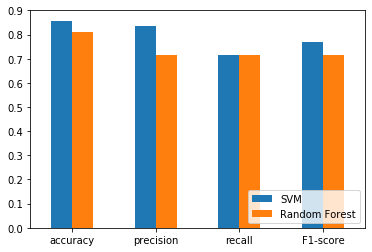

In [17]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()


Both classifiers perform well, but SVM always performs better than Random Forest. I can pick SVM to train a final model on the whole dataset. These results will vary slightly when running this notebook again. Ideally, the code could be enhanced to run the entire experiment multiple times and average the results.

We can also examine the ROC curves of the two classifiers for class 1.

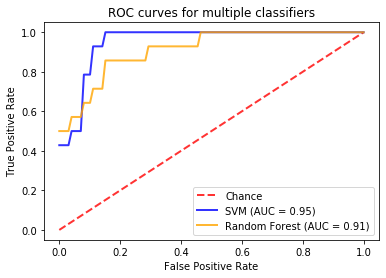

In [18]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()


The ROC curves confirm that both classifiers perform significantly better than a random guess (the red dashed line). 

## Train a Final Model

Finally, I can train a Random Forest model with all data we have, assuming that the more data we have the better the model.

In [19]:
# function to remove the string 'RandomForestClassifier__' from the names of the parameters in RandomForestClassifier_best_params
def transform(dict):
    return {key.replace('RandomForestClassifier__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, RandomForestClassifier(n_estimators=100, 
                               bootstrap = True))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [20]:
filename = 'seeds_final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))
